In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tqdm import tqdm
from scipy.stats import loguniform

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gufra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gufra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("../dataset/9_class/training.csv", skipinitialspace=True)
# df.drop(columns="Unnamed: 0", axis=1, inplace=True)
df.dropna(inplace=True, axis=0)
df.head()

,tanya,jawab,kategori
0,umur saya masih 18 tahun saya tidak obesitasti...,"\n\n<p>Alo, terima kasih atas pertanyaannya un...",Menstruasi
1,hai saya berusia 16 tahun 3 bulan saya mempuny...,"\n\n<p>Selamat pagi, terima kasih telah bertan...",Gigi
2,jika saat saya melakukan sit up kenapa perut s...,"<p>Dear Azizi,\n\nSakit perut sebelah kiri bag...",Cedera
3,belakangan ini saya mengalami diare tapi susah...,"\n\n<p>Alo Adi,</p>\n<p>Terima kasih atas pert...",Demam
4,ter saya perempuan berusia 12 tahun sampe saat...,"\n\n<p>Alo, terimakasih atas pertanyaannya.</p...",Menstruasi


In [3]:
label = {
    'Asam Lambung': 0,
    'Batuk': 1, 
    'Cedera': 2, 
    'Demam': 3,
    'Gatal': 4, 
    'Gigi': 5, 
    'Jerawat': 6, 
    'Menstruasi': 7, 
    'Sakit Kepala': 8
}

df['kategori'] = df['kategori'].map(label)
df.head()

,tanya,jawab,kategori
0,umur saya masih 18 tahun saya tidak obesitasti...,"\n\n<p>Alo, terima kasih atas pertanyaannya un...",7
1,hai saya berusia 16 tahun 3 bulan saya mempuny...,"\n\n<p>Selamat pagi, terima kasih telah bertan...",5
2,jika saat saya melakukan sit up kenapa perut s...,"<p>Dear Azizi,\n\nSakit perut sebelah kiri bag...",2
3,belakangan ini saya mengalami diare tapi susah...,"\n\n<p>Alo Adi,</p>\n<p>Terima kasih atas pert...",3
4,ter saya perempuan berusia 12 tahun sampe saat...,"\n\n<p>Alo, terimakasih atas pertanyaannya.</p...",7


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.tanya, df.kategori, 
    test_size=0.3, 
    stratify=df.kategori,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20157,), (8639,), (20157,), (8639,))

In [5]:
# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(X_train)  # Hanya fit pada data pelatihan

# Sequence
sequence_training = tokenizer.texts_to_sequences(X_train)
sequence_testing = tokenizer.texts_to_sequences(X_test)

# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_length = 200
padded_training = pad_sequences(sequence_training, maxlen=max_sequence_length, padding='post', truncating='post')
padded_testing = pad_sequences(sequence_testing, maxlen=max_sequence_length, padding='post', truncating='post')


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, Input, Embedding, LSTM, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, AdamW, RMSprop, Adagrad, Adadelta, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [7]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64),
    GlobalMaxPool1D(),
    Dense(9, activation='softmax')
])
model.compile(loss=SparseCategoricalCrossentropy(), 
              optimizer=Adam(0.00007),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 320585 (1.22 MB)
Trainable params: 320585 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Train the model with your dataset
history = model.fit(padded_training, y_train, epochs=25, validation_data=(padded_testing, y_test), workers=-1)

Epoch 1/25
630/630 [==============================] - 7s 10ms/step - loss: 2.1842 - accuracy: 0.2353 - val_loss: 2.1634 - val_accuracy: 0.3752
Epoch 2/25
630/630 [==============================] - 5s 9ms/step - loss: 2.1298 - accuracy: 0.5375 - val_loss: 2.0922 - val_accuracy: 0.6414
Epoch 3/25
630/630 [==============================] - 5s 9ms/step - loss: 2.0403 - accuracy: 0.7193 - val_loss: 1.9872 - val_accuracy: 0.7517
Epoch 4/25
630/630 [==============================] - 6s 9ms/step - loss: 1.9175 - accuracy: 0.7782 - val_loss: 1.8509 - val_accuracy: 0.7819
Epoch 5/25
630/630 [==============================] - 6s 9ms/step - loss: 1.7672 - accuracy: 0.8065 - val_loss: 1.6923 - val_accuracy: 0.8037
Epoch 6/25
630/630 [==============================] - 5s 8ms/step - loss: 1.6000 - accuracy: 0.8227 - val_loss: 1.5228 - val_accuracy: 0.8185
Epoch 7/25
630/630 [==============================] - 6s 10ms/step - loss: 1.4274 - accuracy: 0.8350 - val_loss: 1.3534 - val_accuracy: 0.8279
Epoc

In [9]:
# Evaluate the model
loss_train, accuracy_train = model.evaluate(padded_training, y_train)
loss_test, accuracy_test = model.evaluate(padded_testing, y_test)

print(f'Train Loss: {loss_train}')
print(f'Train Accuracy: {accuracy_train*100:.2f}%\n')

print(f'Test Loss: {loss_test}')
print(f'Test Accuracy: {accuracy_test*100:.2f}%')

270/270 [==============================] - 1s 3ms/step - loss: 0.4785 - accuracy: 0.8541
Train Loss: 0.4378091096878052
Train Accuracy: 87.12%

Test Loss: 0.4785344898700714
Test Accuracy: 85.41%


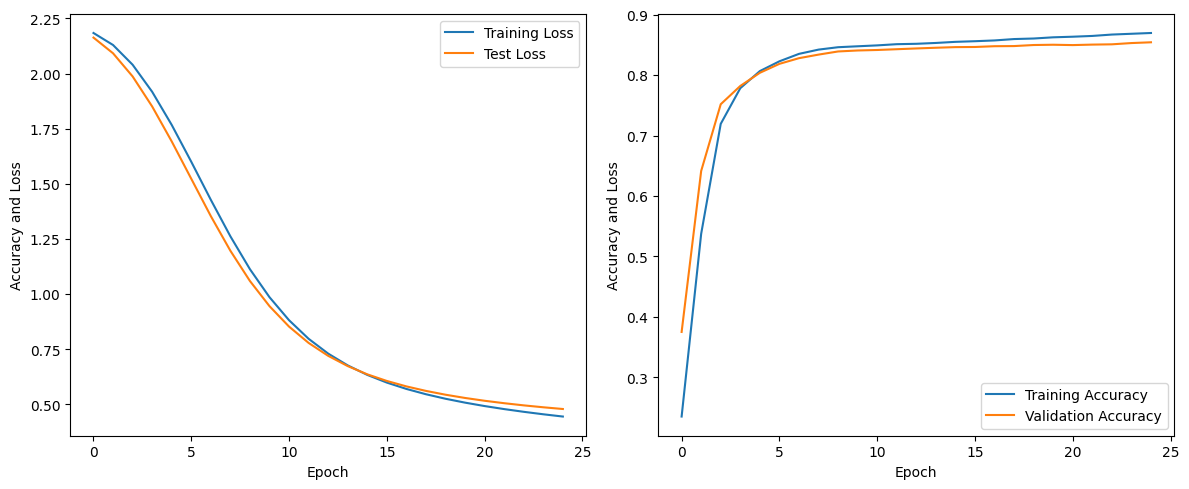

In [10]:
import sys
sys.path.append("../")
from helper import visualize_perform
visualize_perform(history)

In [11]:
prediction = model.predict(padded_testing)

actual = y_test.values

print(actual)
print(np.argmax(prediction, axis=1))

270/270 [==============================] - 1s 3ms/step
[5 4 4 ... 1 2 7]
[5 4 4 ... 1 2 7]


In [12]:
from sklearn.metrics import classification_report

report = classification_report(actual, np.argmax(prediction, axis=1), target_names=label)
print("Laporan Klasifikasi:\n", report)

Laporan Klasifikasi:
               precision    recall  f1-score   support

Asam Lambung       0.80      0.81      0.80       960
       Batuk       0.86      0.86      0.86       959
      Cedera       0.75      0.82      0.78       960
       Demam       0.77      0.71      0.74       960
       Gatal       0.90      0.91      0.90       960
        Gigi       0.95      0.97      0.96       960
     Jerawat       0.96      0.91      0.93       960
  Menstruasi       0.92      0.94      0.93       960
Sakit Kepala       0.79      0.76      0.78       960

    accuracy                           0.85      8639
   macro avg       0.85      0.85      0.85      8639
weighted avg       0.85      0.85      0.85      8639



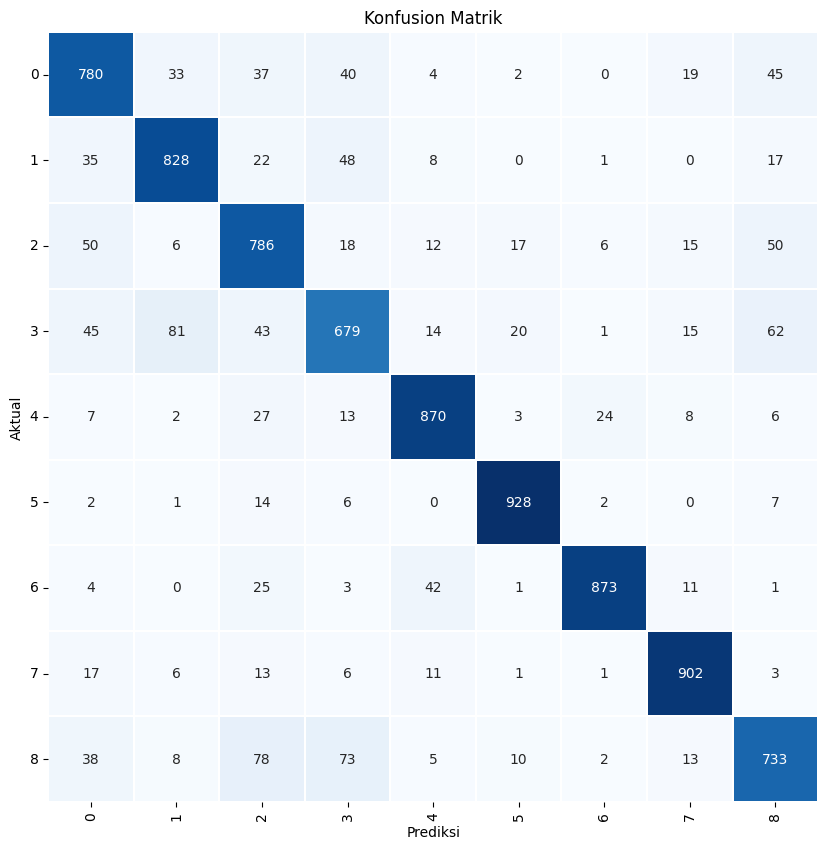

In [13]:
from helper import visualize_matrix
visualize_matrix(actual, prediction)

In [14]:
model.save("../model/model_3_87_85.h5")

d:\codingproject\healthybot\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
